In [1]:
import os
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(10)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.36:47742 Dashboard: http://10.148.0.36:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


---

# automatic extraction of all variables

In [15]:
grid_dir = root_data_dir+'grid/'
out_dir = datawork+'/iwsst_mit/'

def extract(v, it, face, i, j, pref=''):
    
    data_dir = root_data_dir+v+'/'

    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    
    p = 'C'
    if v is 'SSU':
        p = 'W'
    elif v is 'SSV':
        p = 'S'
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    ds = ds.chunk({'face': 1})
    #print(ds)

    file_out = out_dir+pref+v+'.nc'
    #ds[v].isel(time=t, face=face, i=i, j=j).to_netcdf(file_out, mode='w', unlimited_dims='time')
    dv = ds[v].sel(time=time.sel(iters=it)).isel(face=face, i=i, j=j)
    dv = dv.load()
    dv.to_netcdf(file_out, mode='w', unlimited_dims='time')


In [16]:
V = ['Eta', 'SST', 'SSU', 'SSV']
#V = ['Eta', 'SST']
#V = ['SSU']

iters, time = get_iters_time('Eta', root_data_dir+'Eta/', delta_t=25.)
siters = iters.sel(time=slice(152*86400.,178*86400.))

ext = {}
ext['mad'] = {'iters': siters, 'face': 1, 'i': slice(3000,None), 'j': slice(1000,4000)}
ext['nwa'] = {'iters': siters, 'face': 4, 'i': slice(2000,4000), 'j': slice(1500,3500)}

for key, e in ext.items():
    print('face = %d' %e['face'])
    for v in V:
        print(v)
        extract(v, e['iters'], e['face'], e['i'], e['j'], pref=key+'_')

face = 1
Eta


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_sc

SST
SSU
SSV
face = 4
Eta
SST
SSU
SSV


---

# manual exploration in order to get index slices

In [6]:
data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 10311)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=

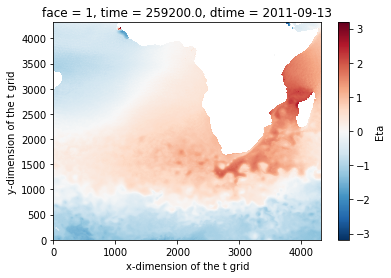

In [7]:
ds['Eta'].isel(time=0, face=1).plot()

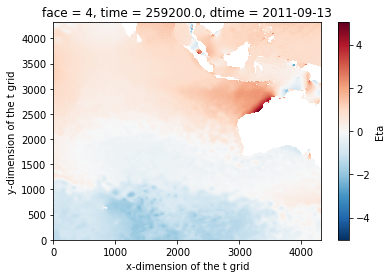

In [8]:
ds['Eta'].isel(time=0, face=4).plot()

In [9]:
print(ds['Eta'])

<xarray.DataArray 'Eta' (time: 10311, face: 13, j: 4320, i: 4320)>
dask.array<shape=(10311, 13, 4320, 4320), dtype=>f4, chunksize=(1, 1, 4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    rA       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    dtime    (time) datetime64[ns] dask.array<shape=(10311,), chunksize=(10311,)>


### produce a netcdf file

In [ ]:
ds.isel(time=slice(0,24), face=1)

In [ ]:
file_out = datawork+'/ssh_extract.nc'
#ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
ds['Eta'].isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time')

---

In [17]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>